In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Add fixed params to dict
params = {}
params['c'] = 0.067
params['s'] = 1
params['sigma'] = 0.28
params['m_w'] = 0.22
params['m_f'] = 0.038
params['m_l'] = 0#0.0275
params['alpha_r'] = 0
params['c_d_max'] = 1
params['a_0'] = 2*np.pi
params['a_1'] = 2*np.pi
#arams['.tau.value = 0
params['w_g'] = 0
params['beta'] = 0.0036
params['V'] = 22.5
params['Lambda'] = np.deg2rad(10)
params['Mode'] = 'Free'

In [3]:
jobs=[]
# Make jobs for FWT geoms
cambers = np.deg2rad([0,5,10])
twists = np.deg2rad([0,-10,10])
sigmas = [0.28,0.4,0.5]
tapers = [0,-0.5,0.5]

iters = [cambers,twists,sigmas,tapers]
names = ['alpha_c','eta_0','sigma','eta_1']

default = [i[0] for i in iters]
jobs =[]
for i,_iter in enumerate(iters):
    row = default.copy()
    for val in _iter:
        row_0 = row.copy()
        row_0[i] = val
        jobs.append(dict(zip(names,row_0)))

# for each job do multiple velocities
vs = np.linspace(15,30,4);
jobs = [{**d,'V':v} for d in jobs for v in np.linspace(15,30,4)] # for each velocity
jobs = [{**d,'beta':v} for d in jobs for v in [0.0037,0.0015]] # for two betas

# make a fixed and free version of each job
jobs = [{**row,**mode}for row in jobs for mode in [{'Mode':'Fixed','m_f':0.038,'a_1':2*np.pi},{'Mode':'Removed','m_f':0,'a_1':0}] ]

len(jobs)

222.30792206144991


{'c': 0.067,
 's': 1,
 'sigma': 0.28,
 'm_w': 0.22,
 'm_f': 0.038,
 'm_l': 0,
 'alpha_r': 0,
 'c_d_max': 1,
 'a_0': 6.283185307179586,
 'a_1': 6.283185307179586,
 'w_g': 0,
 'beta': 0.0015,
 'V': 30,
 'Lambda': 0.17453292519943295,
 'Mode': 'Fixed',
 'alpha_c': 0.0,
 'eta_0': 0.0,
 'eta_1': 0}

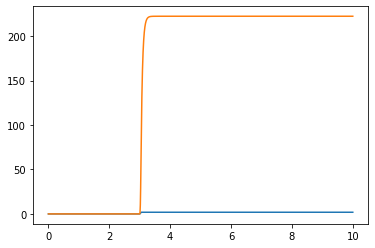

In [4]:
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
#GenRunData('tempModel.py',3,[0]*p.qs*2,10,{**params,**jobs[0]},names,{'Mode':'Free'},100)[100]
data = RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0,0],10,{**params,**jobs[0],'V':22.5,'beta':0.0037},names[:2],{'Mode':'Free',**{n:0 for n in names[2:]}},100)
df = pd.DataFrame(data)
plt.plot(df['t'],df['torque'])
plt.plot(df['t'],np.rad2deg(df['Roll Rate']))

print(np.rad2deg(df[df['t']>4]['Roll Rate'].mean()))
{**params,**jobs[0],'V':30,'beta':0.0015}

In [5]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']

res=[]
for job in jobs:
    res.append(pool.apply_async(RollRig.GenRunData_StepTorque, args = ('RollRigModel-Fixed.py',1,[0]*2,10,{**params,**job},names[:2],{n:0 for n in names[2:]},100)))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 4.38 s, sys: 4.36 s, total: 8.74 s
Wall time: 1min 36s
